In [2]:
import numpy as np
import pandas as pd
import re
from nltk.corpus import stopwords
stop_words=stopwords.words('english')
from nltk.tokenize import word_tokenize
import string
pd.set_option('max_colwidth',200)
from sklearn.feature_extraction import text 
from sklearn.feature_extraction.text import CountVectorizer
from wordcloud import WordCloud
import matplotlib.pyplot as plt


<h1> Getting the data i.e. the Transcripts </h1>

<br>In this case, we will import .txt files containing the transcripts and call the cleaning_transcripts function. 
<br>How did I get the transcripts? -  I googled transcripts for both the presidents and saved the ones given by them at a similar event.
<br>I decided to define a function to open the text files, as we have 20+2 .txt files. 10 for Barack Obama's transcripts and 1 combining all of them (i.e. BO) and 10 for Donald Trump's transcripts and 1 combining all of them (i.e. DT)

In [3]:
def opentxtfile(filename):
    with open(filename,'r') as f:
        lines = [line.strip() for line in f if line.strip()]
        transcripts=''.join(lines)
        
    return transcripts

Open the combined transcripts (BO,DT) files.

In [4]:
BarackObama_transcripts=opentxtfile('BO.txt')
DonaldTrump_transcripts=opentxtfile('DT.txt')
BarackObama_transcripts[0::1000]  #printing 1st 1000 characters to avoid long scrolls.

"{dnp l eterecAtlsstsmesl3tfisbeoos onao dya riz novi dfpey,m aockie camnrons0 llWm tetat\\ari ts  otaviuuic\\cdmio one n'w o'\\t \\vr Iicbhy ,dcevol tsiw   tse m eo,wowoo niy cddcihla,htwoa\\niheo anlfsy"

Looking at the transcripts, we immediately see a pool of back slashes,senseless strings, numbers, etc. Addtionally, I spotted some text like (Applause),[Laughter] which we do not need. Lets clean it by removing all those things.


<h1> Cleaning the Transcripts </h1>

Make all the words lowercase, remove brackets along with the text inside it, remove punctuation and remove words containing numbers

In [5]:
def cleaning_transcripts(transcripts):
    transcripts = transcripts.lower()
    transcripts = re.sub('\((.*?\))', '', transcripts)
    transcripts = re.sub('\[.*?\]', '', transcripts)
    transcripts = re.sub('[%s]' % re.escape(string.punctuation), '', transcripts)
    transcripts = re.sub('\w*\d\w*', '', transcripts)
    return transcripts


In [6]:
BO_cleaned_transcripts=cleaning_transcripts(BarackObama_transcripts)
DT_cleaned_transcripts=cleaning_transcripts(DonaldTrump_transcripts)
BO_cleaned_transcripts[0::1000]

'  tp amrf try h ryhne d uf evoadoe neyprha rue ifcmonahnoceontriholit nd murdr ruhces  ebetpdeotogte aemrrhaawht ihl pustnmek ene tlpmeos dse c hoito iiouo  n goe eeteeta mf a'

<h1> Remove the stopwords</h1>

In [7]:
def remove_stopwords(transcripts):
    tokenized_transcripts=word_tokenize(transcripts)
    transcripts_wo_stopwords= [w for w in tokenized_transcripts if not w in stop_words] 
    transcripts_wo_stopwords=' '.join(transcripts_wo_stopwords)    
    return transcripts_wo_stopwords


In [8]:
BO_cleaned_transcripts=remove_stopwords(BO_cleaned_transcripts)
DT_cleaned_transcripts=remove_stopwords(DT_cleaned_transcripts)


<h1> Organise the Transcripts into a Data Frame</h1>

In [9]:
df_transcripts=pd.DataFrame({"Transcripts" :(BO_cleaned_transcripts,DT_cleaned_transcripts) },index= ("Barack","Donald"))
df_transcripts


,Transcripts
Barack,fellow americans tonight like talk years tradition welcoming immigrants around world given us tremendous advantage nations kept us youthful dynamic entrepreneurial shaped character people limitles...
Donald,listname listname well thank working hard tell sometimes make easy certainly make easy continue tradition might arthur know agree know arthur going like going love listening really thank muchand t...


<h1> Create Word Clouds </h1>



In [10]:
def word_cloud(name,transcript,color_map,x):
    wc = WordCloud(stopwords=stop_words, width = 300, height = 250,background_color="white", colormap=color_map,
                   max_font_size=75, random_state=60)
    plt.rcParams['figure.figsize'] = [x,x]
    wc.generate(transcript)
    plt.subplot(3,4,3)
    plt.imshow(wc, interpolation="bilinear")
    plt.axis("off")
    plt.title(name)
    plt.show()

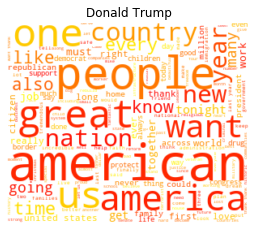

In [11]:
word_cloud('Donald Trump',DT_cleaned_transcripts,'autumn',20)

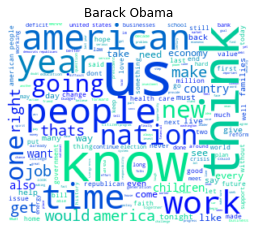

In [12]:
word_cloud('Barack Obama',BO_cleaned_transcripts,'winter',20)

As you can see, there isn't much difference in the two word clouds. Top words like American, people, nation are common between both. To get more insights, I want to remove the top common words and some more words I dont want to include in my word cloud.

<h1> Creating a document-term matrix </h1>

Creating a document-term matrix using CountVectorizer, and excluding the common English stop words

In [13]:
from sklearn.feature_extraction.text import CountVectorizer
cv = CountVectorizer(stop_words='english')
data_cv = cv.fit_transform(df_transcripts.Transcripts)
data_dtm = pd.DataFrame(data_cv.toarray(), columns=cv.get_feature_names())
data_dtm.index = df_transcripts.index
data_dtm

,abandoned,abandonment,abbottabad,abedini,abess,abide,ability,able,aboard,abraham,...,youll,young,youre,youth,youthank,youthful,youve,youwell,zardari,zero
Barack,1,0,1,3,1,1,6,19,0,0,...,1,10,1,0,0,1,4,0,1,0
Donald,0,1,0,0,0,1,1,9,1,1,...,0,12,0,3,1,0,1,1,0,1


In [14]:
data = data_dtm
data = data.transpose()
data

,Barack,Donald
abandoned,1,0
abandonment,0,1
abbottabad,1,0
abedini,3,0
abess,1,0
...,...,...
youthful,1,0
youve,4,1
youwell,0,1
zardari,1,0


<h1> Finding the top 25 words </h1>

In [15]:
top_words=[]
top_dict = {}
for c in data.columns:
    top = data[c].sort_values(ascending=False).head(25)
    top_dict[c]= list(zip(top.index, top.values))

top_dict

{'Barack': [('people', 126),
  ('know', 102),
  ('think', 96),
  ('american', 76),
  ('make', 76),
  ('time', 70),
  ('going', 67),
  ('work', 67),
  ('new', 67),
  ('years', 63),
  ('country', 61),
  ('americans', 60),
  ('nation', 59),
  ('america', 59),
  ('right', 59),
  ('economy', 58),
  ('thats', 57),
  ('year', 56),
  ('jobs', 54),
  ('want', 53),
  ('children', 49),
  ('like', 47),
  ('health', 46),
  ('care', 46),
  ('tonight', 43)],
 'Donald': [('people', 102),
  ('american', 89),
  ('great', 75),
  ('want', 68),
  ('thank', 68),
  ('america', 68),
  ('new', 56),
  ('country', 53),
  ('americans', 49),
  ('going', 44),
  ('like', 43),
  ('time', 43),
  ('tonight', 42),
  ('know', 40),
  ('years', 36),
  ('united', 36),
  ('world', 35),
  ('nation', 35),
  ('work', 32),
  ('year', 32),
  ('congress', 29),
  ('love', 28),
  ('states', 28),
  ('right', 27),
  ('really', 26)]}

<h1> Creating a list of words that we don't want in our word clouds </h1>

Even after removing the top words from the word cloud, I wasn't quite happy with the way it turned out. So I decided to manually add some words in the list that weren't stop words or top words but yet they didnt bring in much value to the word clouds. 
Additionally, I decided to keep 'great' as it is an important word from Donald Trump's first campaign slogan. 
After creating the list, I added it to stop_words so that those words won't appear in the word clouds.

In [16]:
additional_stop_words=[]
for key, val in top_dict.items():
    for i in range(15):
        additional_stop_words.append(val[i][0])
additional_stop_words.remove('great')
additional_stop_words.extend(['us','year','one','get','would','every','also','many','thats', 'must','much','last','thing','see','come','even'])
stop_words+=additional_stop_words


<h1>And Creating the Final Word Clouds</h1>

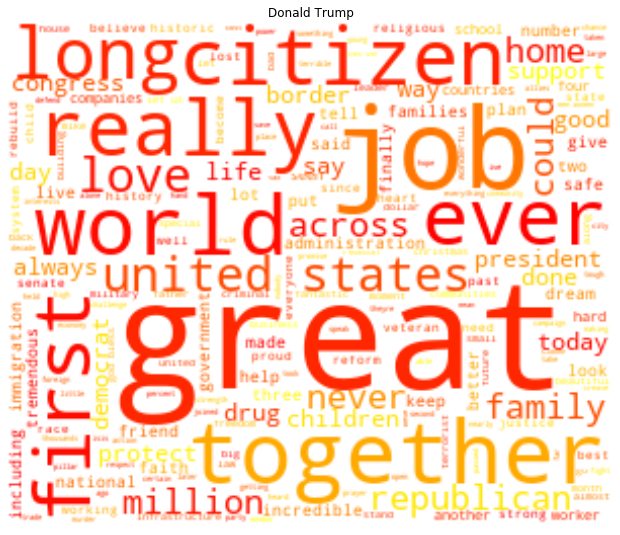

In [17]:
word_cloud('Donald Trump',DT_cleaned_transcripts,'autumn',50)

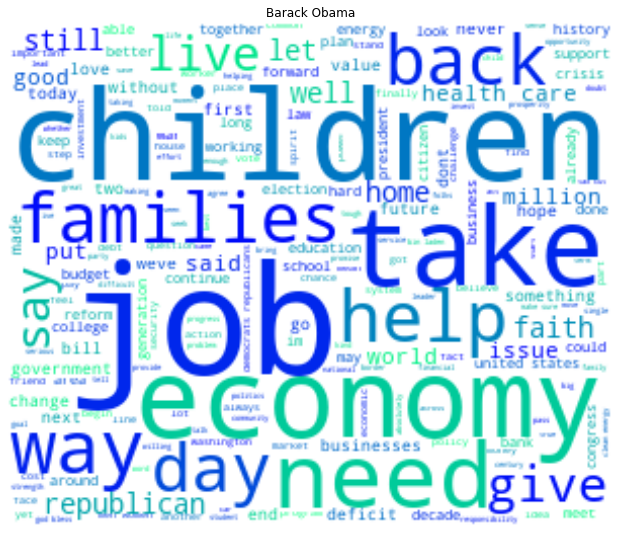

In [18]:
word_cloud('Barack Obama',BO_cleaned_transcripts,'winter',50)

<h1> Size of Vocabulary </h1>


We can figure out the size of the vocabulary by using the document term matrix. We look for words with non-zero values for each president.

In [19]:
unique_list = []
full_names=['Barack','Donald']
for president in data.columns:
    uniques = data[president].to_numpy().nonzero()[0].size
    unique_list.append(uniques)

# Create a new dataframe that contains this unique word count
data_words = pd.DataFrame(list(zip(full_names, unique_list)), columns=['President', 'Total Unique words'])
data_words 

,President,Total Unique words
0,Barack,3723
1,Donald,3061


<h4>TextBlob Module:</h4> Linguistic researchers have labeled the sentiment of words based on their domain expertise. Sentiment of words can vary based on where it is in a sentence. The TextBlob module allows us to take advantage of these labels.
<br>
<h4>Sentiment Labels:</h4> Each word in a corpus is labeled in terms of polarity and subjectivity (there are more labels as well, but we're going to ignore them for now). A corpus' sentiment is the average of these.

<br></br>

<li>Polarity: How positive or negative a word is. -1 is very negative. +1 is very positive.
<li>Subjectivity: How subjective, or opinionated a word is. 0 is fact. +1 is very much an opinion.

In [20]:
BO_Deathof_transcript=opentxtfile('BO_Death of Osama Bin Laden.txt')
DT_Deathof_transcript=opentxtfile('DT_Death of Abu Bakr al-Baghdadi.txt')
BO_Deathof_transcript=cleaning_transcripts(BO_Deathof_transcript)
DT_Deathof_transcript=cleaning_transcripts(DT_Deathof_transcript)

df_Deathof_transcript=pd.DataFrame({'Transcripts': [BO_Deathof_transcript,DT_Deathof_transcript]},index=['Barack', 'Donald'])
df_Deathof_transcript


,Transcripts
Barack,tonight i can report to the american people and to the world that the united states has conducted an operation that killed osama bin laden the leader of al qaeda and a terrorist responsible...
Donald,night the united states brought the number one terrorist leader to justice abu bakr albaghdadi is he was the founder and leader of isis the most ruthless and violent terror organization in ...


I decided to go with the Death of Transcripts to calculate polarity and subjectivity. <br> </br>
BO_Deathof_transcript is President Barack Obama's transcript of the speech in which he addressed the Nation to announce that the United States has killed Osama bin Laden <br> </br>
DT_Deathof_transcript is President Donald Trump's transcript of the remarks by him on the Death of ISIS Leader Abu Bakr al-Baghdadi

In [21]:
from textblob import TextBlob

pol = lambda x: TextBlob(x).sentiment.polarity
sub = lambda x: TextBlob(x).sentiment.subjectivity


df_Deathof_transcript['Polarity'] = df_Deathof_transcript['Transcripts'].apply(pol)
df_Deathof_transcript['Subjectivity'] = df_Deathof_transcript['Transcripts'].apply(sub)
df_Deathof_transcript

,Transcripts,Polarity,Subjectivity
Barack,tonight i can report to the american people and to the world that the united states has conducted an operation that killed osama bin laden the leader of al qaeda and a terrorist responsible...,0.111840,0.433855
Donald,night the united states brought the number one terrorist leader to justice abu bakr albaghdadi is he was the founder and leader of isis the most ruthless and violent terror organization in ...,-0.035873,0.570527


In [22]:
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker

def plot_fn(df_transcript,measure):
    fig = plt.figure(figsize=(30, 2))

    # draw lines
    xmin = -1
    xmax = 1
    y = 5
    height = 2

    plt.hlines(y, xmin, xmax)
    plt.vlines(xmin, y - height / 2., y + height / 2.)
    plt.vlines(xmax, y - height / 2., y + height / 2.)

    # draw a point on the line
    px1 = df_Deathof_transcript[measure]['Barack']
    plt.plot(px1,y, 'bo', ms = 30, mfc = 'b')

    px2 = df_Deathof_transcript[measure]['Donald']
    plt.plot(px2,y, 'ro', ms = 30, mfc = 'r')
    
    
    plt.title(measure, loc='center', pad=50,fontsize=50)
    plt.text(px1,y+1,round(px1,2),horizontalalignment='center',verticalalignment='center',fontsize=25)
    plt.text(px2,y+1,round(px2,2),horizontalalignment='center',verticalalignment='center',fontsize=25)

    # add numbers
    if(measure=='Polarity'):
        plt.text(xmin - 0.01, y, 'Negative(-1)', horizontalalignment='right',verticalalignment='center',fontsize=30)
       
        plt.text(px1,y-1.5,'Barack Obama',horizontalalignment='left',verticalalignment='center',fontsize=25)
        plt.text(px2,y-1.5,'Donald Trump',horizontalalignment='right',verticalalignment='center',fontsize=25)
        plt.text(xmax + 0.01, y, 'Positive(+1)', horizontalalignment='left',verticalalignment='center',fontsize=30)
       
    else:
        plt.text(xmin - 0.01, y, 'Objective(0)', horizontalalignment='right',verticalalignment='center',fontsize=30)
        plt.text(xmin-0.1 , y-1.5, 'Fact', horizontalalignment='left',verticalalignment='center',fontsize=30)

        plt.text(px1,y-1.5,'Barack Obama',horizontalalignment='right',verticalalignment='center',fontsize=25)
        plt.text(px2,y-1.5,'Donald Trump',horizontalalignment='left',verticalalignment='center',fontsize=25)
        plt.text(xmax + 0.01, y, 'Subjective(1)', horizontalalignment='left',verticalalignment='center',fontsize=30)
        plt.text(xmax + 0.04, y-1.5, 'Opinion', horizontalalignment='left',verticalalignment='center',fontsize=30)
       

    plt.axis('off')
    plt.show()

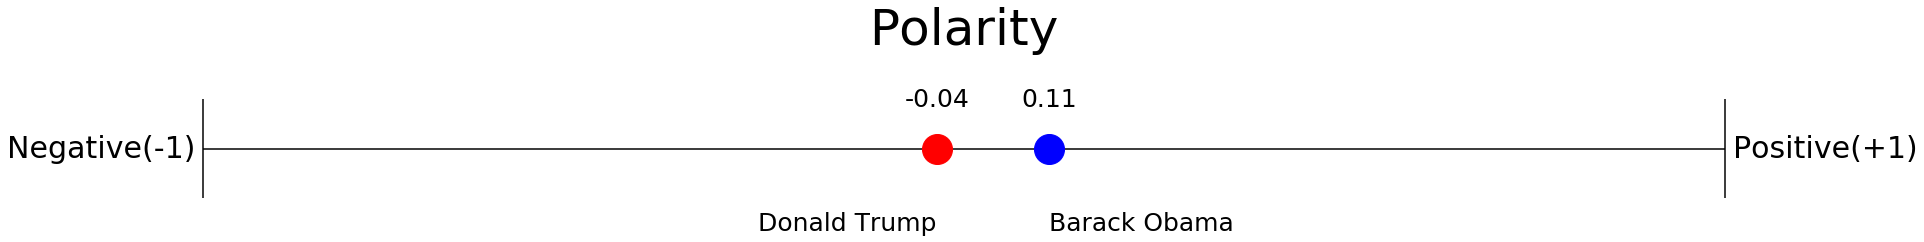

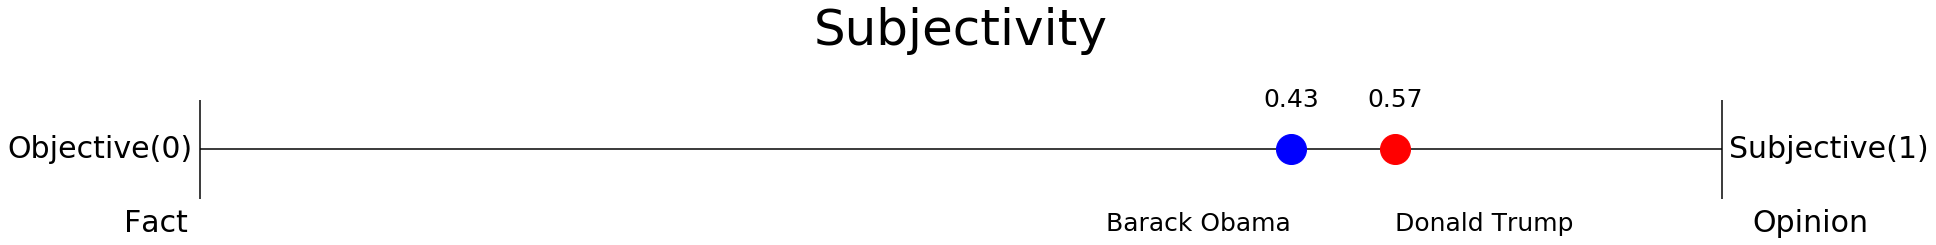

In [23]:
plot_fn(df_Deathof_transcript,'Polarity')
plot_fn(df_Deathof_transcript,'Subjectivity')

<h1>Creating a dataframe with all the transcripts and the names of the events, for some more analysis</h1>

Opening all the text files

In [24]:
BO_SchoolShooting_transcript=opentxtfile('BO_School Shooting.txt')
DT_SchoolShooting_transcript=opentxtfile('DT_School Shooting.txt')

BO_Victory_transcript=opentxtfile('BO_Victory Speech.txt')
DT_Victory_transcript=opentxtfile('DT_Victory Speech.txt')

BO_StateUnionAddress_transcript=opentxtfile('BO_State of the Union Address.txt')
DT_StateUnionAddress_transcript=opentxtfile('DT_State of the Union Address.txt')

BO_IntroVP_transcript=opentxtfile('BO_Introducing VP.txt')
DT_IntroVP_transcript=opentxtfile('DT_Introducing VP.txt')

BO_InauguralSpeech_transcript=opentxtfile('BO_Inaugural Speech.txt')
DT_InauguralSpeech_transcript=opentxtfile('DT_Inaugural Speech.txt')

BO_Immigration_transcript=opentxtfile('BO_Immigration.txt')
DT_Immigration_transcript=opentxtfile('DT_Immigration.txt')

BO_Christmas_transcript=opentxtfile('BO_Christmas.txt')
DT_Christmas_transcript=opentxtfile('DT_Christmas.txt')

BO_AnnualPrayerBreakfast_transcript=opentxtfile('BO_Annual National Prayer Breakfast.txt')
DT_AnnualPrayerBreakfast_transcript=opentxtfile('DT_Annual National Prayer Breakfast.txt')

BO_AddressCongress_transcript=opentxtfile('BO_Address to Joint Session of Congress.txt')
DT_AddressCongress_transcript=opentxtfile('DT_Address to Joint Session of Congress.txt')



Creating a Dataframe

In [25]:
data = {'Name':['Barack', 'Donald','Barack', 'Donald','Barack', 'Donald','Barack', 'Donald','Barack', 'Donald','Barack', 'Donald','Barack', 'Donald','Barack', 'Donald','Barack', 'Donald','Barack', 'Donald'],'Event' : ['School Shooting','School Shooting','Victory','Victory','State of the Union Address','State of the Union Address','Introducing VP Joe Biden','Introducing VP Mike Pence','Inaugural Speech','Inaugural Speech','Immigration','Immigration,','Christmas','Christmas','Annual National Prayer Breakfast','Annual National Prayer Breakfast','Address to Joint Session of Congress','Address to Joint Session of Congress','Death of Osama Bin Laden ','Death of Abu Bakr Al-Baghdadi'], 'Transcripts':[BO_SchoolShooting_transcript,DT_SchoolShooting_transcript,BO_Victory_transcript,DT_Victory_transcript,BO_StateUnionAddress_transcript,DT_StateUnionAddress_transcript,BO_IntroVP_transcript,DT_IntroVP_transcript,BO_InauguralSpeech_transcript,DT_InauguralSpeech_transcript,BO_Immigration_transcript,DT_Immigration_transcript,BO_Christmas_transcript,DT_Christmas_transcript,BO_AnnualPrayerBreakfast_transcript,DT_AnnualPrayerBreakfast_transcript,BO_AddressCongress_transcript,DT_AddressCongress_transcript,BO_Deathof_transcript,DT_Deathof_transcript]}

df_all_transcripts = pd.DataFrame(data) 
df_all_transcripts.head()


,Name,Event,Transcripts
0,Barack,School Shooting,{\rtf1\ansi\ansicpg1252\cocoartf2513\cocoatextscaling0\cocoaplatform0{\fonttbl\f0\fswiss\fcharset0 Helvetica;}{\colortbl;\red255\green255\blue255;\red50\green49\blue51;\red255\green255\blue255;}{\...
1,Donald,School Shooting,{\rtf1\ansi\ansicpg1252\cocoartf2513\cocoatextscaling0\cocoaplatform0{\fonttbl\f0\fswiss\fcharset0 Helvetica;}{\colortbl;\red255\green255\blue255;\red50\green49\blue51;\red255\green255\blue255;}{\...
2,Barack,Victory,{\rtf1\ansi\ansicpg1252\cocoartf2513\cocoatextscaling0\cocoaplatform0{\fonttbl\f0\fnil\fcharset0 Georgia;}{\colortbl;\red255\green255\blue255;\red38\green38\blue38;\red255\green255\blue255;\red0\g...
3,Donald,Victory,{\rtf1\ansi\ansicpg1252\cocoartf2513\cocoatextscaling0\cocoaplatform0{\fonttbl\f0\fswiss\fcharset0 Helvetica;}{\colortbl;\red255\green255\blue255;\red29\green29\blue29;\red254\green254\blue254;}{\...
4,Barack,State of the Union Address,{\rtf1\ansi\ansicpg1252\cocoartf2513\cocoatextscaling0\cocoaplatform0{\fonttbl\f0\fswiss\fcharset0 Helvetica;}{\colortbl;\red255\green255\blue255;\red50\green49\blue51;\red255\green255\blue255;}{\...


<h1> Cleaning the transcripts in the data frame </h1>

In [26]:
for i in range(len(df_all_transcripts)):
    df_all_transcripts['Transcripts'][i]=cleaning_transcripts(df_all_transcripts['Transcripts'][i])
df_all_transcripts.head()

,Name,Event,Transcripts
0,Barack,School Shooting,you to all the families first responders to the community of newtown clergy guests scripture tells us not lose heart outwardly we are wasting we are being renewed day by for our light a...
1,Donald,School Shooting,fellow americans today i speak to a nation in grief yesterday a school filled with innocent children and caring teachers became the scene of terrible violence hatred and around yesterday a...
2,Barack,Victory,there is anyone out there who still doubts that america is a place where all things are possible who still wonders if the dream of our founders is alive in our time who still questions the po...
3,Donald,Victory,listname listname you thank you very much everybody sorry to keep you waiting complicated business complicated thank you very ive just received a call from secretary clinton she congrat...
4,Barack,State of the Union Address,speaker vice president biden members of congress distinguished guests and fellow our constitution declares that from time to time the president shall give to congress information about the ...


<h1>Sentiment of Speeches Over Time</h1>


Instead of looking at the overall sentiment, let's see if there's anything interesting about the sentiment over time 
throughout each speech.

I have split each transcript into 10 parts and plot the polarity of each part for each transcript.

In [27]:
import numpy as np
import math

def split_text(text, n=10):
    '''Takes in a string of text and splits into n equal parts, with a default of 10 equal parts.'''

    # Calculate length of text, the size of each chunk of text and the starting points of each chunk of text
    length = len(text)
    size = math.floor(length / n)
    start = np.arange(0, length, size)
    
    # Pull out equally sized pieces of text and put it into a list
    split_list = []
    for piece in range(n):
        split_list.append(text[start[piece]:start[piece]+size])
    return split_list

In [28]:
BO_split=[]
DT_split=[]
for i in range(0,20,2):
    BO_split.append(split_text(df_all_transcripts.iat[i,2]))
for i in range(1,20,2):
    DT_split.append(split_text(df_all_transcripts.iat[i,2]))


In [29]:
BO_polarity=[]
DT_polarity=[]
for i in range(10):
    for j in range(10):
        BO_polarity.append(TextBlob(BO_split[i][j]).sentiment.polarity)
        DT_polarity.append(TextBlob(DT_split[i][j]).sentiment.polarity)


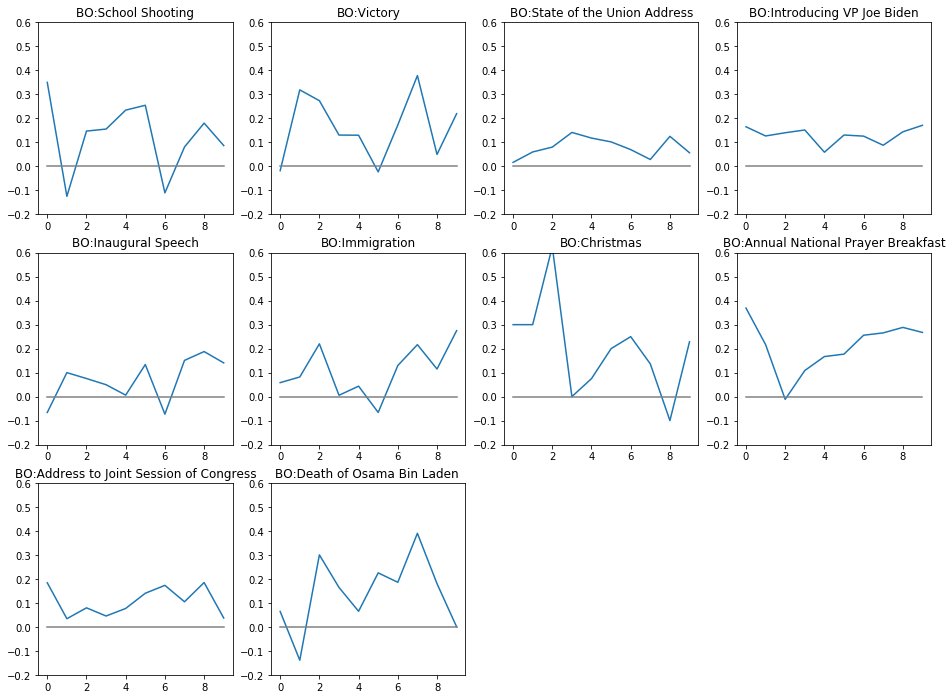

In [30]:
plt.rcParams['figure.figsize'] = [16, 12]
n=0
nw=0
for nr in range(0,100,10):    
    plt.subplot(3, 4, n+1)
    n+=1
    
    plt.plot(BO_polarity[nr:nr+10])
    plt.plot(np.arange(0,10), np.zeros(10),color='grey')
    plt.title("BO:"+df_all_transcripts.iat[nw,1])
    nw+=2
    plt.ylim(ymin=-.2, ymax=.6)
    
plt.show()


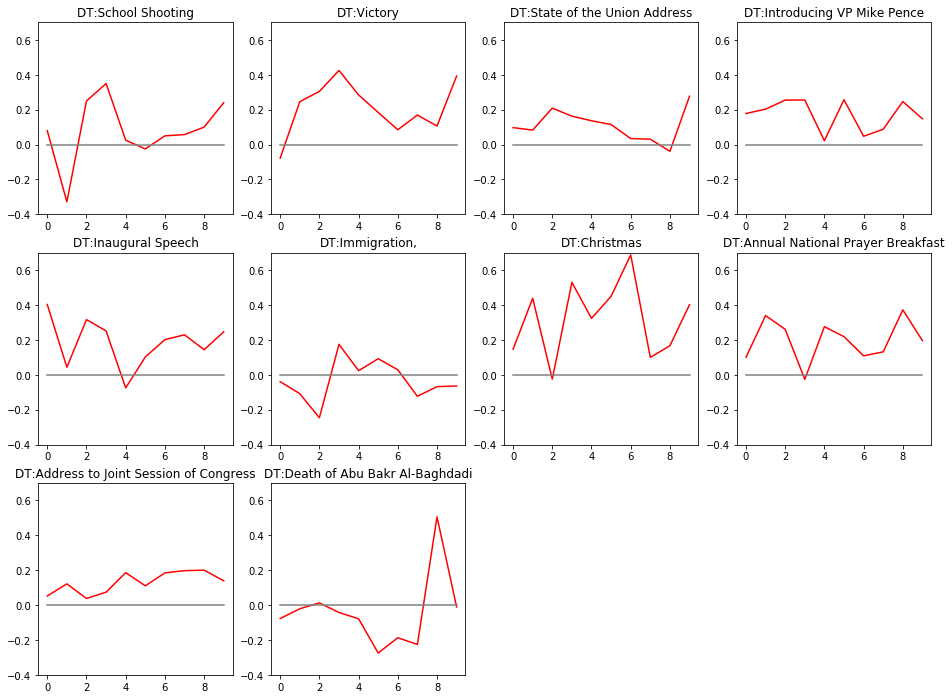

In [31]:
plt.rcParams['figure.figsize'] = [16, 12]
n=0
nw=1
for nr in range(0,100,10):    
    plt.subplot(3, 4, n+1)
    n+=1
    
    plt.plot(DT_polarity[nr:nr+10],color='red')
    plt.plot(np.arange(0,10), np.zeros(10),color='grey')
    plt.title("DT:"+df_all_transcripts.iat[nw,1])
    nw+=2
    plt.ylim(ymin=-.4, ymax=.7)
    
plt.show()